In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT, GroverOperator
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from math import pi, sqrt, sin
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import functools
from utils import get_image_path
from utils import fibonacci as recursive_fibonacci
from tqdm.notebook import tqdm_notebook

In [2]:
def simulate(qc, shots=1000, backend=AerSimulator()):
    transpiled_circuit = transpile(qc, backend) if not isinstance(backend, Sampler) else qc
    return backend.run(transpiled_circuit, shots=shots)
    
def get_counts(job):
    return job.result().get_counts()


In [3]:
def fibonacci(n):
    qc = QuantumCircuit(n)
    qc.ry(pi/2, range(n))

    if(n > 1):
        for i in range(0, n-1):
            qc.cry(-pi/2, i, i+1)
    return qc

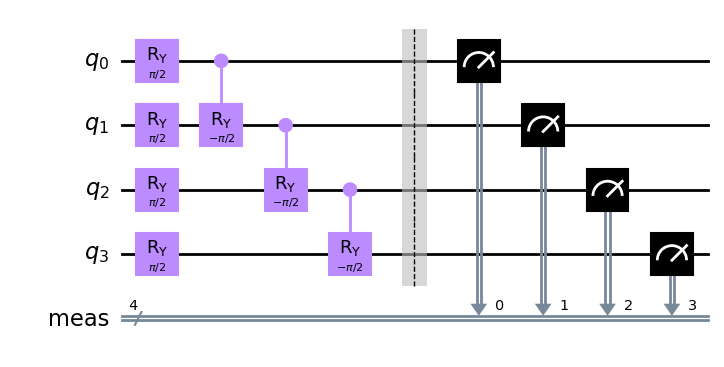

In [4]:
qc = fibonacci(4)
qc.measure_all()
qc.draw('mpl', filename=get_image_path("fibonacci-circuit.png"))

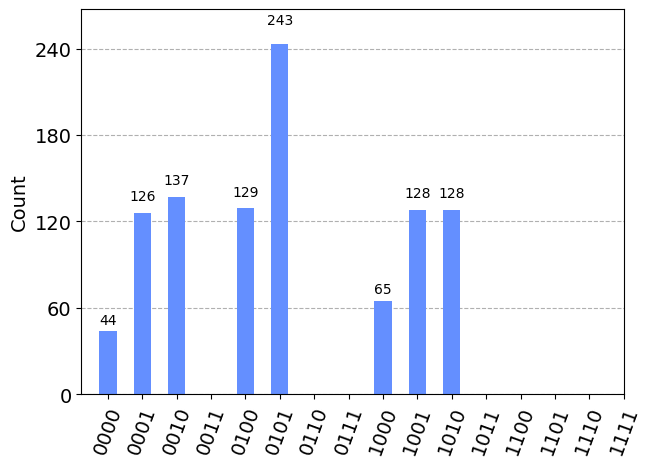

In [5]:
job = simulate(qc)
counts = get_counts(job)

def complete_results(counts):
    results = {}
    for bit_string in product('01', repeat=len(qc.qubits)):
        bit_string = ''.join(bit_string)
        results[bit_string] = 0 if counts.get(bit_string) is None else counts[bit_string]
    return results

fig= plot_histogram(complete_results(counts))
fig.savefig(get_image_path('fibonacci-4.png'))
display(fig)

# Fibonacci Sequence

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144

starting from 2

2, 3, 5, 8, 13, 21, 34, 55, 89, 144

F(4) = 8

In [6]:
def get_fibonacci_number(counts):
    return len(counts)

In [7]:
# F(4)
get_fibonacci_number(counts)

8

In [9]:
def evaluate_fibonacci_quantum(n, shots=1000):
    qc = fibonacci(n)
    qc.measure_all()
    job = simulate(qc, shots=shots)
    counts = get_counts(job)
    return get_fibonacci_number(counts)

In [10]:
x_values = list(range(1,15))
y_values = {"classical":[recursive_fibonacci(n+1) for n in x_values], "quantum":[]}

def comparation(shots=1000):
    y_values["quantum"] = []
    for n in x_values:
        y_values["quantum"].append(evaluate_fibonacci_quantum(n, shots))
    return y_values

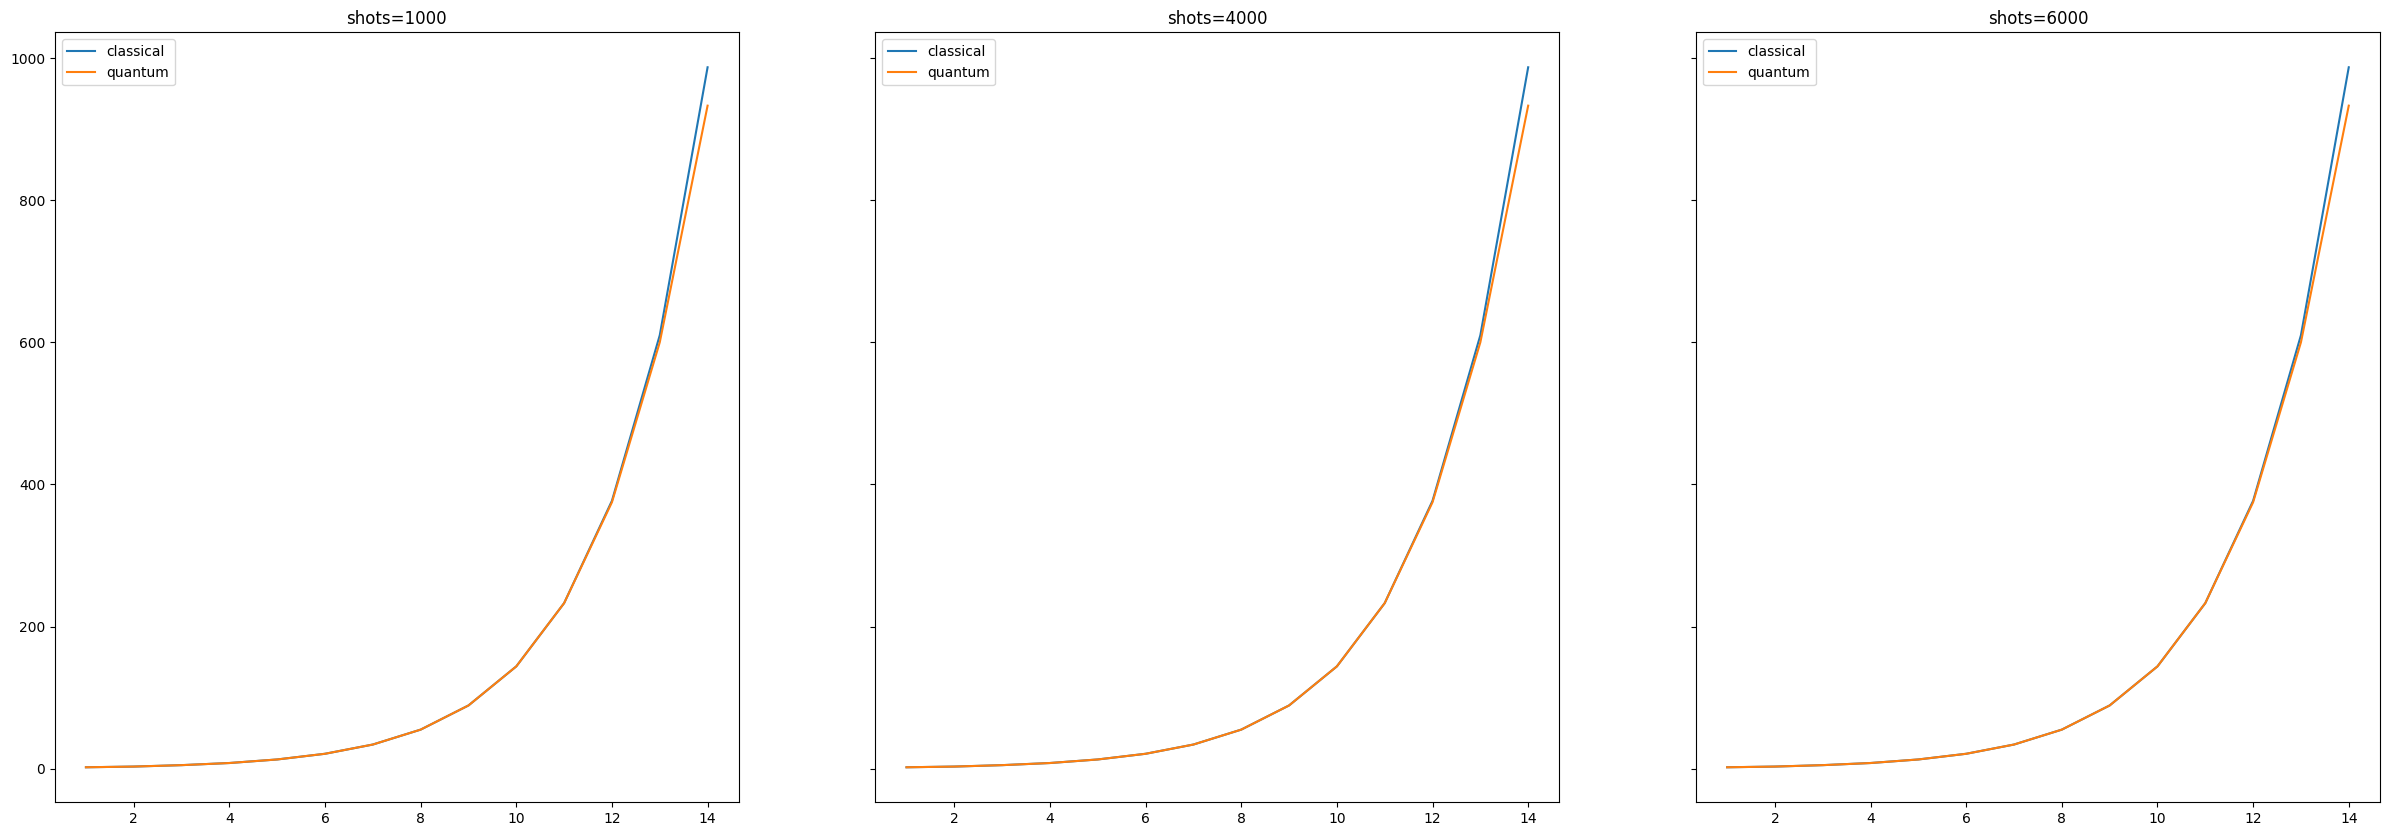

In [11]:
y_values_1000 = comparation(shots=1000)
y_values_4000 = comparation(shots=4000)
y_values_6000 = comparation(shots=6000)

x = pd.Series(x_values)

y_1000 = pd.DataFrame(y_values_1000)
y_4000 = pd.DataFrame(y_values_4000)
y_6000 = pd.DataFrame(y_values_6000)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(30, 10))

#plt.title("Comparation between quantum and classical Fibonacci algorithm")
ax1.plot(x, y_1000)
ax1.legend(labels=["classical", "quantum"])
ax1.set_title("shots=1000")

ax2.plot(x, y_4000)
ax2.legend(labels=["classical", "quantum"])
ax2.set_title("shots=4000")

ax3.plot(x, y_6000)
ax3.legend(labels=["classical", "quantum"])
ax3.set_title("shots=6000")

plt.show()
f.savefig(get_image_path('comparation.png'))

In [12]:
def fibonacci_oracle(n):
    qc = QuantumCircuit(n, name="oracle")
    
    #from https://arxiv.org/pdf/2006.10656.pdf
    predicate = lambda k: k & k >> 1 == 0

    max_value = int('1'*n, 2)
    for k in range(max_value):
        if(predicate(k)):
            bit_string = format(k, 'b').zfill(n)[::-1]
            zeros = [index for index, bit in enumerate(bit_string) if bit == '0' ] 
            qc.x(zeros)
            qc.mcp(pi, list(range(1, n)), 0)
            qc.x(zeros)
            
    return qc

In [13]:
def show_unitary(qc):
    sim = AerSimulator()
    qc_unitary = qc.copy()
    qc_unitary.save_unitary()
    unitary = sim.run(transpile(qc_unitary, sim), shots=1000).result().get_unitary()
    display(array_to_latex(unitary, max_size=100000))

<IPython.core.display.Latex object>

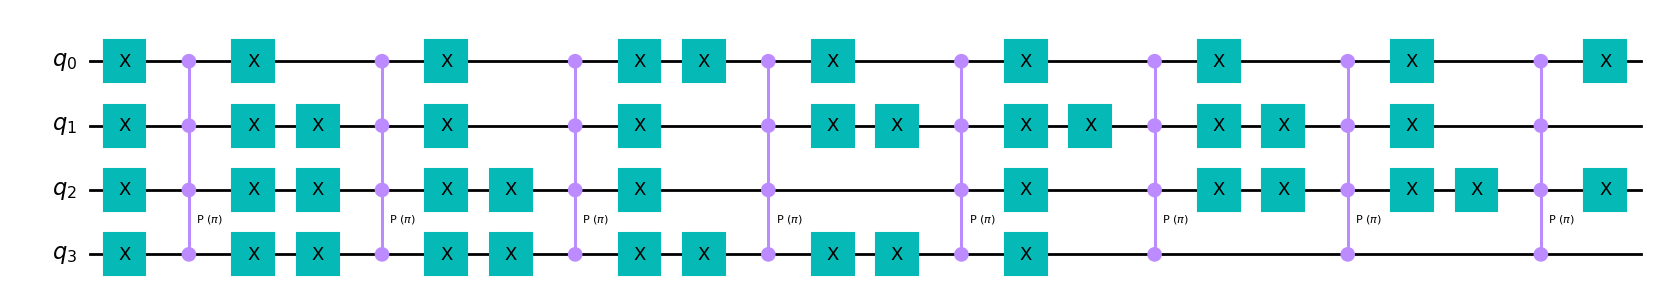

In [14]:
n = 4
oracle = fibonacci_oracle(n)
show_unitary(oracle)
oracle.draw('mpl')

In [15]:
def create_grover_operator(n_iterations, oracle):
    grover = GroverOperator(oracle, name="grover").repeat(n_iterations).to_gate().control()
    return grover

In [16]:
def create_qft_dagger(n):
    return QFT(n, inverse=True).to_gate(label="QFT†")

In [17]:
def create_quantum_couting_algorithm(n, oracle):
    total_qubits = n*2

    qc = QuantumCircuit(total_qubits, n)
    qc.h(range(total_qubits))
    iterations = 1
    for qubit in range(n):
        qc.append(create_grover_operator(iterations, oracle), [qubit] + list(range(n, total_qubits)))
        iterations *= 2
    
    qc.append(create_qft_dagger(n), list(range(n)))
    qc.measure(range(n), range(n))
    
    return qc

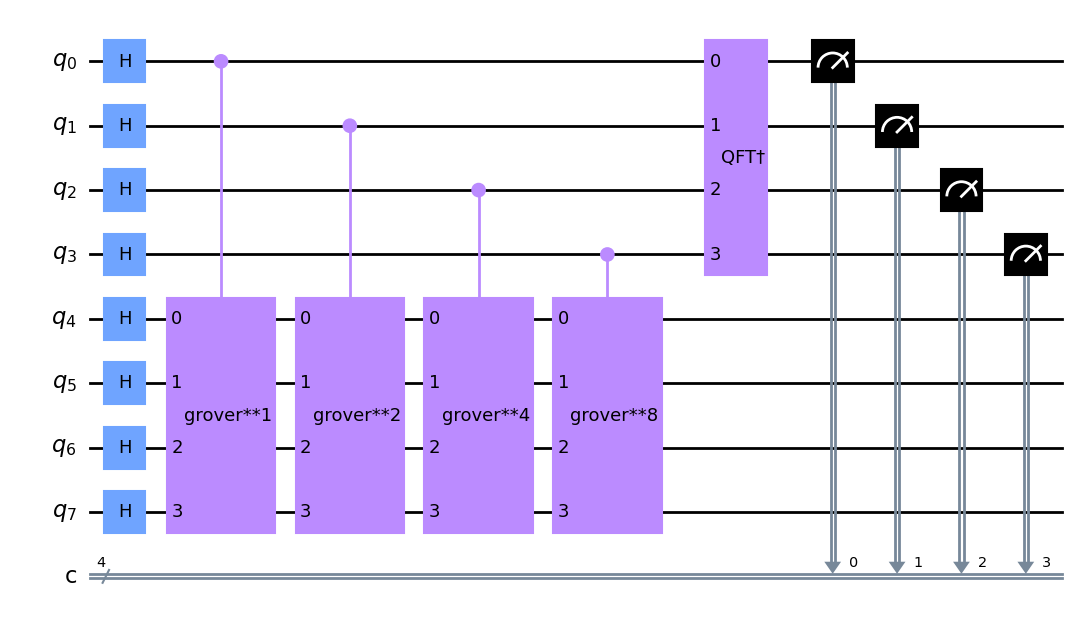

In [18]:
qc = create_quantum_couting_algorithm(n, oracle)
qc.draw('mpl', filename=get_image_path("quantum_counting.png"))

In [31]:
def get_dist(job):
    dists = job.result().quasi_dists
    print(dists)
    return dists[0]

In [35]:
def get_total_results(dist):
    measured_str = max(dist, key=dist.get)
    theta =  (measured_str/(2**n))*pi*2
    N = 2 ** n
    M = N * (sin(theta/2)**2)
    return M

In [21]:
def evaluate_fibonacci_quantum_2(n, shots):
    progress = tqdm_notebook(total=3)
    
    oracle = fibonacci_oracle(n)
    progress.update(1)
    
    qc = create_quantum_couting_algorithm(n, oracle)
    progress.update(1)
    
    dist = get_dist(simulate(qc, backend=Sampler()))
    progress.update(1)
    
    return get_total_results(dist)

In [27]:
x_values = list(range(2,7))
y_values = {"classical":[recursive_fibonacci(n+1) for n in x_values], "quantum":[]}

def comparation_2(shots=1000):
    y_values["quantum"] = []
    
    for n in x_values:
        y_values["quantum"].append(evaluate_fibonacci_quantum_2(n, shots))
    return y_values

  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.067, 1: 0.369, 2: 0.156, 3: 0.408}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.024, 1: 0.033, 2: 0.361, 3: 0.081, 4: 0.028, 5: 0.085, 6: 0.351, 7: 0.037}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{4: 0.5, 12: 0.5}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{6: 0.001, 7: 0.477, 18: 0.001, 25: 0.52, 26: 0.001}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.001, 2: 0.001, 4: 0.001, 6: 0.001, 7: 0.001, 8: 0.007, 9: 0.004, 10: 0.008, 11: 0.02, 12: 0.272, 13: 0.157, 14: 0.02, 15: 0.006, 16: 0.005, 17: 0.003, 18: 0.001, 19: 0.002, 20: 0.001, 21: 0.001, 23: 0.001, 29: 0.002, 30: 0.002, 33: 0.001, 37: 0.001, 40: 0.001, 42: 0.001, 43: 0.001, 44: 0.001, 45: 0.002, 46: 0.001, 47: 0.001, 48: 0.007, 49: 0.01, 50: 0.017, 51: 0.147, 52: 0.259, 53: 0.017, 54: 0.002, 55: 0.008, 57: 0.001, 58: 0.001, 59: 0.002, 63: 0.002}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.066, 1: 0.374, 2: 0.183, 3: 0.377}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.018, 1: 0.029, 2: 0.352, 3: 0.088, 4: 0.031, 5: 0.087, 6: 0.373, 7: 0.022}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{4: 0.517, 12: 0.483}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{7: 0.483, 24: 0.001, 25: 0.514, 26: 0.001, 27: 0.001}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 6: 0.002, 7: 0.003, 8: 0.001, 9: 0.005, 10: 0.007, 11: 0.026, 12: 0.269, 13: 0.134, 14: 0.02, 15: 0.013, 16: 0.002, 18: 0.002, 19: 0.001, 20: 0.001, 21: 0.001, 22: 0.001, 24: 0.001, 27: 0.001, 31: 0.001, 32: 0.001, 40: 0.001, 43: 0.001, 45: 0.001, 46: 0.002, 47: 0.001, 48: 0.004, 49: 0.009, 50: 0.017, 51: 0.164, 52: 0.257, 53: 0.027, 54: 0.004, 55: 0.006, 56: 0.004, 57: 0.002, 58: 0.001, 59: 0.001, 60: 0.001, 62: 0.001}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.069, 1: 0.38, 2: 0.161, 3: 0.39}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.01, 1: 0.031, 2: 0.342, 3: 0.109, 4: 0.034, 5: 0.093, 6: 0.349, 7: 0.032}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{4: 0.503, 12: 0.497}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{7: 0.478, 8: 0.002, 23: 0.001, 24: 0.001, 25: 0.516, 26: 0.001, 27: 0.001}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.002, 1: 0.001, 4: 0.001, 5: 0.001, 7: 0.002, 8: 0.003, 9: 0.003, 10: 0.004, 11: 0.019, 12: 0.273, 13: 0.157, 14: 0.017, 15: 0.008, 16: 0.002, 17: 0.003, 18: 0.002, 19: 0.001, 21: 0.002, 22: 0.001, 23: 0.002, 24: 0.002, 25: 0.001, 27: 0.001, 28: 0.001, 29: 0.001, 33: 0.001, 35: 0.001, 40: 0.001, 44: 0.001, 45: 0.002, 46: 0.002, 47: 0.001, 48: 0.003, 49: 0.006, 50: 0.024, 51: 0.158, 52: 0.24, 53: 0.032, 54: 0.007, 55: 0.004, 56: 0.002, 58: 0.001, 60: 0.001, 62: 0.003}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.058, 1: 0.389, 2: 0.183, 3: 0.37}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.015, 1: 0.034, 2: 0.376, 3: 0.094, 4: 0.02, 5: 0.089, 6: 0.341, 7: 0.031}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{4: 0.501, 12: 0.499}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{7: 0.513, 8: 0.002, 25: 0.484, 26: 0.001}]


  0%|          | 0/3 [00:00<?, ?it/s]

[{0: 0.002, 1: 0.001, 4: 0.001, 5: 0.003, 6: 0.002, 7: 0.003, 8: 0.003, 9: 0.002, 10: 0.004, 11: 0.03, 12: 0.256, 13: 0.156, 14: 0.018, 15: 0.008, 16: 0.008, 17: 0.004, 18: 0.001, 19: 0.003, 20: 0.002, 21: 0.002, 22: 0.001, 31: 0.001, 35: 0.001, 36: 0.001, 41: 0.001, 43: 0.001, 44: 0.001, 45: 0.001, 46: 0.001, 47: 0.003, 48: 0.003, 49: 0.01, 50: 0.024, 51: 0.148, 52: 0.256, 53: 0.019, 54: 0.005, 55: 0.002, 56: 0.002, 57: 0.004, 58: 0.001, 59: 0.001, 61: 0.001, 62: 0.001, 63: 0.002}]


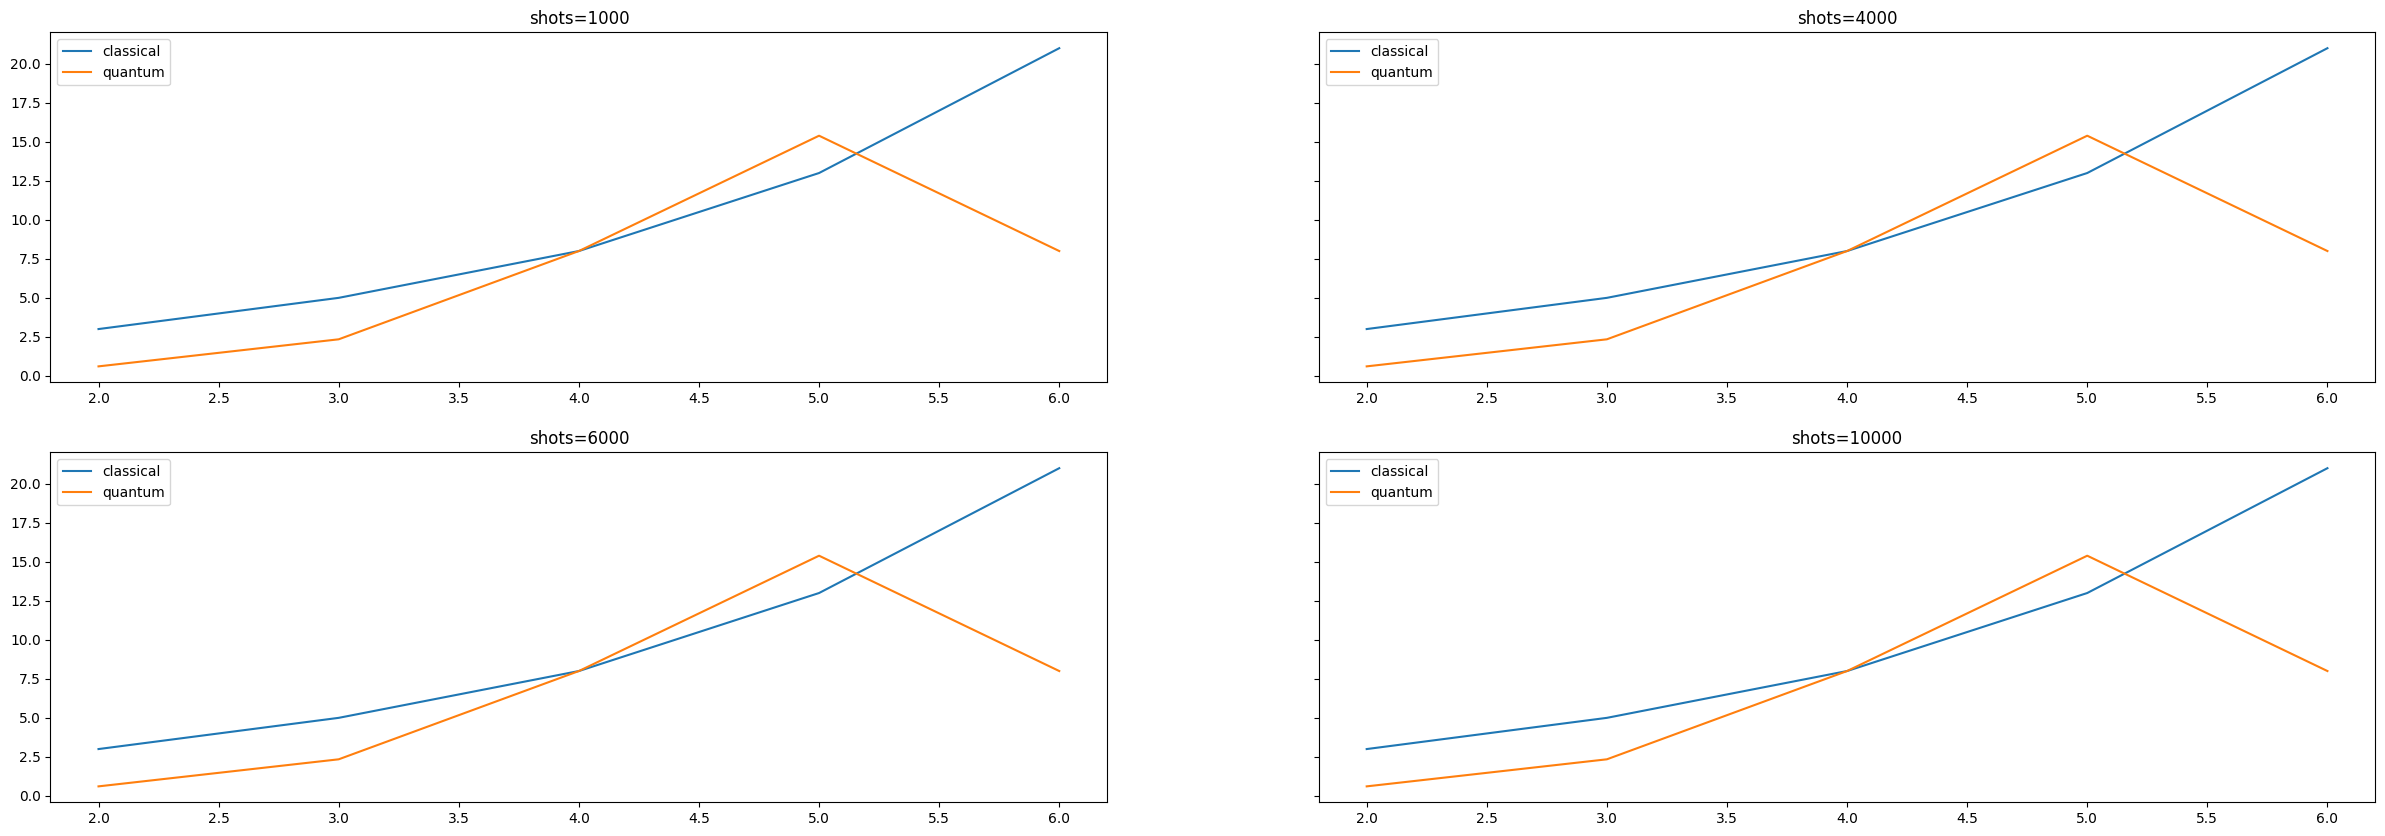

In [36]:
y_values_1000 = comparation_2(shots=1000)
y_values_4000 = comparation_2(shots=4000)
y_values_6000 = comparation_2(shots=6000)
y_values_10000 = comparation_2(shots=10000)

x = pd.Series(x_values)

y_1000 = pd.DataFrame(y_values_1000)
y_4000 = pd.DataFrame(y_values_4000)
y_6000 = pd.DataFrame(y_values_6000)
y_10000 = pd.DataFrame(y_values_10000)

f, ax = plt.subplots(2, 2, sharey=True, figsize=(30, 10))

ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

#plt.title("Comparation between quantum and classical Fibonacci algorithm")
ax1.plot(x, y_1000)
ax1.legend(labels=["classical", "quantum"])
ax1.set_title("shots=1000")

ax2.plot(x, y_4000)
ax2.legend(labels=["classical", "quantum"])
ax2.set_title("shots=4000")

ax3.plot(x, y_6000)
ax3.legend(labels=["classical", "quantum"])
ax3.set_title("shots=6000")

ax4.plot(x, y_10000)
ax4.legend(labels=["classical", "quantum"])
ax4.set_title("shots=10000")

plt.show()
f.savefig(get_image_path('comparation2.png'))